## Load Data

In [1]:
import csv
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

correction = 0.2 # this is a parameter to tune  

# Load CSV containg image data1
lines = []
#with open('driving_log.csv') as csvfile:
with open('data/driving_log.csv') as csvfile:    
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

# since we are on AWS need  but the paths in$
# of the file are for windows we need to spl$
# the path for AWS

#pull out center, left, and right cameras
#split path on / and pull out filename
images = [] #list of all images
measurements = [] #list of corresponding steering angle
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1] #use ('\\') for windows
        #current_path = 'IMG/' + filename
        current_path = 'data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image) # Store images as a list
        measurement = float(line[3]) #center
        if i==0:
            measurements.append(measurement) #store steering angle as list
        elif i==1:
            measurement+=correction
            measurements.append(measurement) #left
        elif i==2:
            measurement-=correction
            measurements.append(measurement) #right
            
#convert dataset to numpy arrays
X_train = np.array(images)
y_train = np.array(measurements)
del images
del measurements
del lines



print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)

X_train Images Shape (24108, 160, 320, 3)
y_train Steering Angle Shape (24108,)


## Histogram vs Angle

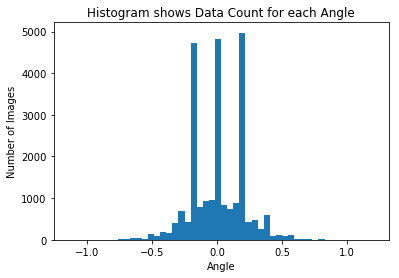

In [2]:

# histogram of label frequency
plt.hist(y_train, bins=50)
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

## Data Augmentation - Flip

In [3]:
augmented_images, augmented_measurements = [],[]

for image, measurement in zip(X_train, y_train):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)
del augmented_images
del augmented_measurements        

X_train Images Shape (48216, 160, 320, 3)
y_train Steering Angle Shape (48216,)


## Histogram vs Angle

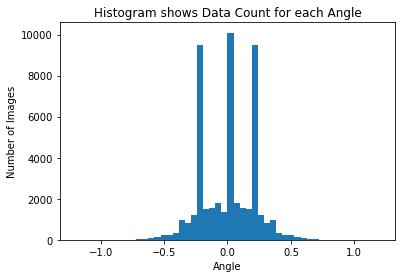

In [4]:

# histogram of label frequency
plt.hist(y_train, bins=50)
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

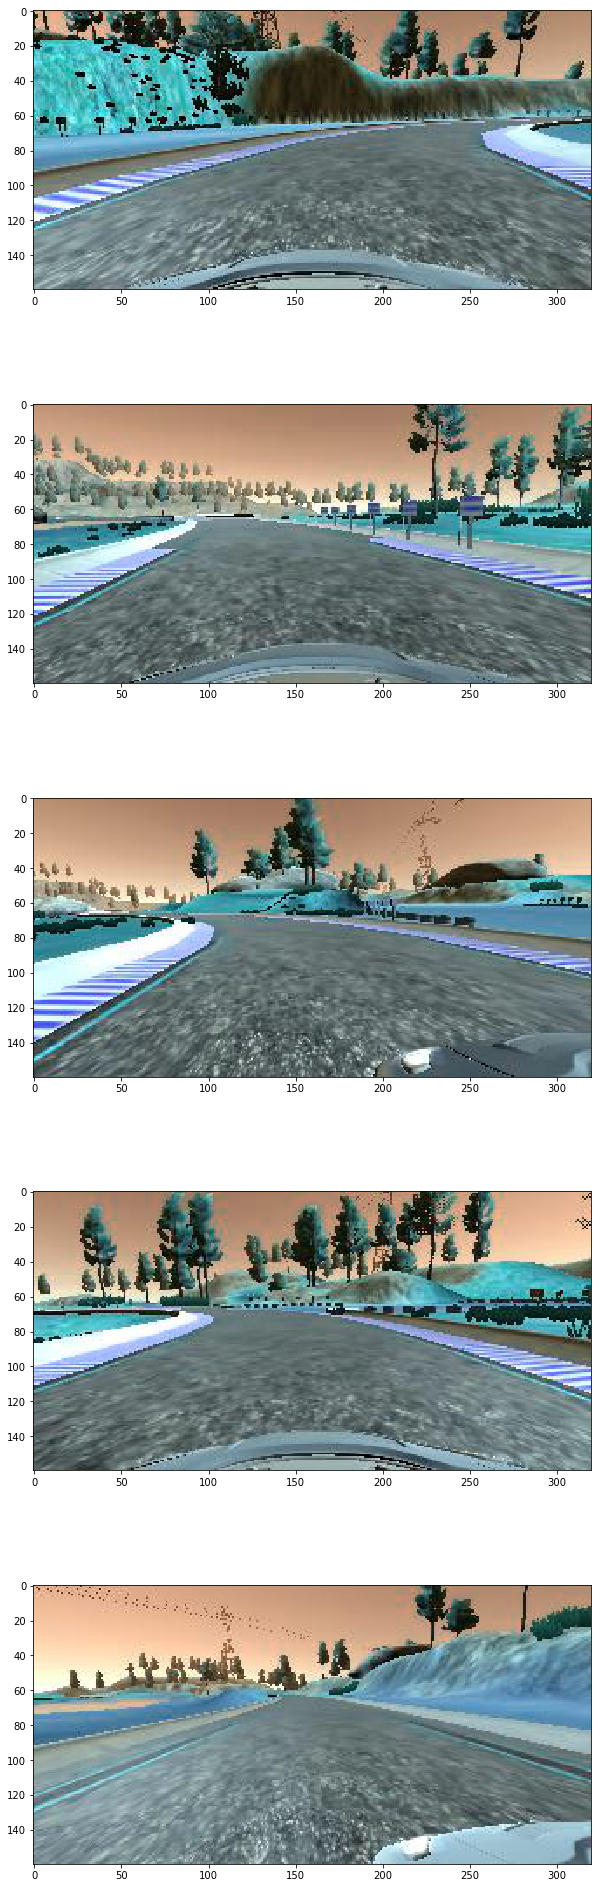

In [5]:
i_range = random.sample(range(1, len(X_train)), 5)
#print (i_range)

#create 5x5 subplot window
fig, ax = plt.subplots(5,1,figsize=(10, 35))

#for each category, find random 5 indicies of their occurance, and plot the image
for i, cat in enumerate(i_range):
    img = X_train[cat]
    ax[i].imshow(img)
    

## Keras Nueral Network - Regression Network

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D


model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, nb_epoch=4)

model.save('model.h5')

Using TensorFlow backend.


Train on 33751 samples, validate on 14465 samples
Epoch 1/4
33751/33751 [==============================] - 103s - loss: 0.0292 - val_loss: 0.0228
Epoch 2/4
33751/33751 [==============================] - 99s - loss: 0.0211 - val_loss: 0.0228
Epoch 3/4
33751/33751 [==============================] - 99s - loss: 0.0202 - val_loss: 0.0246
Epoch 4/4
33751/33751 [==============================] - 97s - loss: 0.0199 - val_loss: 0.0219


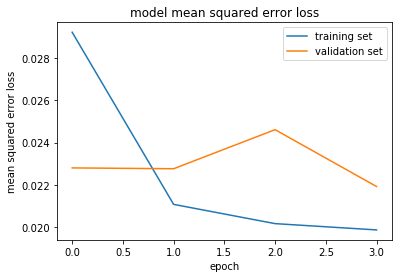

In [7]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()